# Blended Meso 1 & 2 + SODAK

In [1]:
##################################################
#
# Libraries
#





from metpy.plots    import colortables
from metpy.plots    import add_timestamp
from datetime       import datetime
from siphon.catalog import TDSCatalog
from datetime       import datetime


import numpy             as np
import os                as os
import pandas            as pd
import pathlib           as pathlib

import metpy
import cartopy.crs       as ccrs
import cartopy.feature   as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as patches





#
##################################################

In [2]:
##################################################
#
# Channel Labels
#

MAINDIR = os.getcwd() +"/"
print(MAINDIR)

alpha_factor = 0.05

dt_time_meso = 1 # minutes
dt_time_sdm  = 5 # minutes

nt_time_meso = 3 
nt_time_sdm  = int(nt_time_meso/dt_time_sdm)

delay_time_meso =   5 
delay_time_sdm  =  int(delay_time_meso * dt_time_sdm / dt_time_meso)



channel_vis =                        2
channel_tir =                       13

channel_lab = [' Channel Zero',                     #  0
               ' [0.47 µm Blue-Visible]',           #  1
               ' [0.64 µm Red-Visible]',            #  2
               ' [0.86 µm Vegetation Near-IR]',     #  3
               ' [1.37 µm Cirrus Near-IR]',         #  4
               ' [1.6 µm Snow/Ice Near-IR]',        #  5
               ' [2.2 µm Cloud Particle Near-IR]',  #  6
               ' [3.9 µm Middle Infrared]',         #  7
               ' [6.2 µm Upper-Level Water Vapor]', #  8
               ' [6.9 µm Mid-Level Water Vapor]',   #  9
               ' [7.3 µm Low-Level Water Vapor]',   # 10
               ' [8.4 µm Cloud-Top Infrared]',      # 11
               ' [9.6 µm Ozone Infrared]',          # 12
               ' [10.3 µm Clean IR Window]',        # 13
               ' [11.2 µm Middle IR Window]',       # 14
               ' [12.3 µm Dirty IR Window]',        # 15
               ' [13.3 µm CO₂ Infrared]']           # 16

gif_file_name1  = "./graphics_files/RealTime_SAT_IR_Meso1_Loop.gif"
gif_file_name2  = "./graphics_files/RealTime_SAT_IR_Meso2_Loop.gif"
gif_file_name3  = "./graphics_files/RealTime_SAT_IR_SODAK_Loop.gif"
gif_file_name12 = "./graphics_files/RealTime_SAT_IR_Meso12_Loop.gif"

png_file_dir1  = "./temp_files_sat_meso1/"
png_file_dir2  = "./temp_files_sat_meso2/"
png_file_dir3  = "./temp_files_sat_sodak/"

i_rap_t      =  801
j_rap_t      =  231

imin_rap_tir =  551 # i_rap-250
imax_rap_tir = 1051 # i_rap+250
jmin_rap_tir =    0 # j_rap-250+19
jmax_rap_tir =  500 # j_rap+250-19

imin_rap_vis = 1103*2 # np.argmin(np.abs(x_vis-x_min_t).values)
imax_rap_vis = 2102*2 # np.argmin(np.abs(x_vis-x_max_t).values)
jmin_rap_vis =    0*2 # np.argmin(np.abs(y_vis-y_min_t).values)
jmax_rap_vis = 1000*2 # np.argmin(np.abs(y_vis-y_max_t).values)

#
##################################################

/Users/wjc/GitHub/SD_Mines_Map_Wall/


## Meso Floater 1

In [3]:
##################################################
#
# Control Setup
#

# %load solutions/data_url.py

total_frames = nt_time_meso

# Cell content replaced by load magic replacement.

# Create variables for URL generation

image_date  = datetime.utcnow().date()
region      =            'Mesoscale-1'

if (region == 'Mesoscale-1') :
    region_lab               = " Meso-1 Band "
    png_processing_directory = png_file_dir1
    gif_file_name            = gif_file_name1

if (region == 'Mesoscale-2') :
    region_lab               = ' Meso-2 Band '
    png_processing_directory = png_file_dir2
    gif_file_name            = gif_file_name2

    
if (region == 'CONUS') :
    region_lab               = ' SODAK Band '
    png_processing_directory = png_file_dir3
    gif_file_name            = gif_file_name3

# We want to match something like:
# https://thredds-test.unidata.ucar.edu/thredds/catalog/satellite/goes16/GOES16/Mesoscale-1/Channel08/20181113/catalog.html

# Construct the data_url string

data_url_vis = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                f'CloudAndMoistureImagery/{region}/Channel{channel_vis:02d}/current/catalog.xml')

data_url_tir = ('https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/'
                f'CloudAndMoistureImagery/{region}/Channel{channel_tir:02d}/current/catalog.xml')


# Print out your URL and verify it works!

print(data_url_vis)
print(data_url_tir)

#
##################################################

https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/Mesoscale-1/Channel02/current/catalog.xml
https://thredds.ucar.edu/thredds/catalog/satellite/goes/east/products/CloudAndMoistureImagery/Mesoscale-1/Channel13/current/catalog.xml


In [4]:
##################################################
#
# Pull Catalog
#

cat_vis = TDSCatalog(data_url_vis)
cat_tir = TDSCatalog(data_url_tir)

#
##################################################

In [5]:
##################################################
#
# Create File Inventories
#

file_names_to_retain = list()
file_names_to_use    = list()


for i in range(len(cat_vis.datasets)-total_frames,len(cat_vis.datasets),1) :
    filename = cat_vis.datasets[i].name.replace(".nc",".png")
    filename = filename[:20] + "xx" + filename[22:]
    filename = png_processing_directory + filename
    file_names_to_retain.append(filename)
    file_names_to_use.append(filename)
        
files_on_hand = [png_processing_directory + s for s in os.listdir(png_processing_directory)]

file_names_to_retain.sort()
file_names_to_use.sort()

file_names_to_use_meso1 = file_names_to_use.copy()

#
##################################################    

In [6]:
##################################################
#
# Clean PNG Directory
#

for filename in files_on_hand:
    if filename not in file_names_to_retain:
        print("Purging ", filename )
        os.remove( filename  )
    else:
        print("Keeping ", filename )
#
##################################################    

pixels :  2 (2000, 2000)
Fraction of Missings :  0.0
2022-11-06 19:20:28 UTC 2022-11-06 12:20:28 MST
12:20:28
12 370.0742723067762
20 122.8


/var/folders/0c/8xbkg06s6cz0yy2505h06nlm00017d/T/ipykernel_62799/4123883885.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


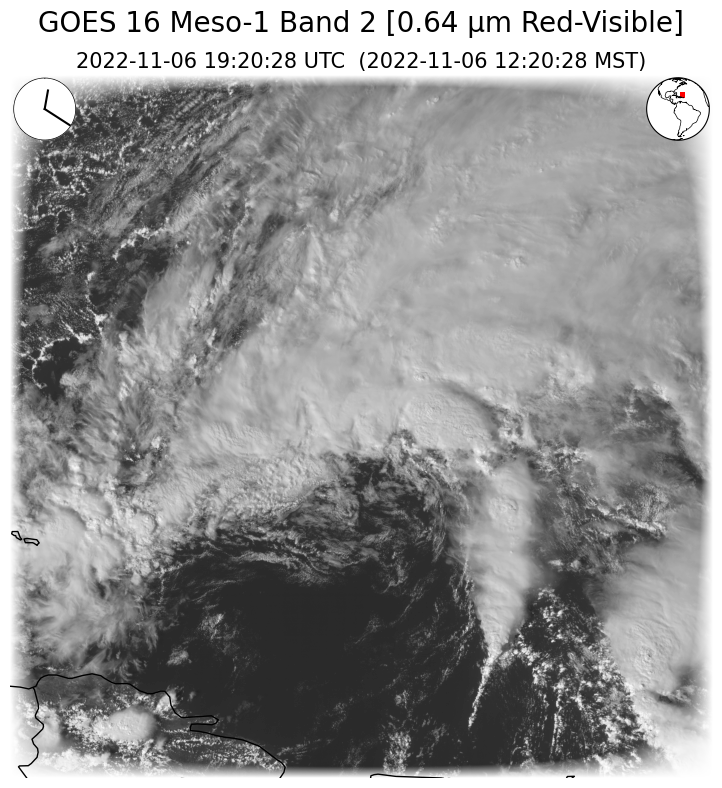

In [7]:
##################################################
#
# Create PNGs
#

for i in range(1) :

    dataset_vis = cat_vis.datasets[i]
    dataset_tir = cat_tir.datasets[i]

    
    filename = dataset_vis.name.replace(".nc", ".png")
    filename = filename[:20] + "xx" + filename[22:]
    dataset_png_file_name = png_processing_directory + filename
    
    
   ################# 

    channel = channel_vis

    ds  = dataset_vis.remote_access(use_xarray=True)
    dat = ds.metpy.parse_cf('Sectorized_CMI')

    print("pixels : ",channel,dat.values.shape)

    frac_missing = np.isnan(dat.values).sum()/np.isnan(dat.values).size
    print("Fraction of Missings : ", frac_missing)

    if(frac_missing > 0.05):
        print("Switching to IR")
        channel = channel_tir
        ds      = dataset_tir.remote_access(use_xarray=True)
        dat     = ds.metpy.parse_cf('Sectorized_CMI')

    proj = dat.metpy.cartopy_crs
    x = dat['x']
    y = dat['y']

    #if(any(dat == np.nan):



    tz         = 'America/Denver'
    time_utc   = datetime.strptime(ds.start_date_time, '%Y%j%H%M%S')
    valid_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").strftime("%Y-%m-%d %H:%M:%S %Z")
    local_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").tz_convert(tz=tz).strftime("%Y-%m-%d %H:%M:%S %Z")

    file_time = pd.to_datetime(time_utc).tz_localize(tz="UTC").strftime("%Y-%m-%d_%H%M")

    print(valid_time,local_time)

    image_header_label = "GOES 16" + region_lab + str(channel)+ channel_lab[channel]


    ny = dat.shape[0]
    nx = dat.shape[1]      
    alpha2d = np.sqrt(np.outer(np.abs(np.hanning(ny)),np.abs(np.hanning(nx))))
    alpha2d = np.where(alpha2d>alpha_factor,alpha_factor,alpha2d)
    alpha2d = alpha2d / alpha_factor




    fig = plt.figure(figsize=(8, 8), facecolor = 'white')

    plt.suptitle(image_header_label,
                 fontsize = 20, 
                 color    = "black")
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.set_title(valid_time + "  (" + local_time+")",
                 fontsize =      15, 
                 color    = "black")
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=1)
    ax.add_feature(cfeature.STATES.with_scale('50m'),    linestyle=':', edgecolor='black')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'),   linewidth=1, edgecolor='black')


    if (channel >= 7):

        im = ax.imshow(                        dat, 
                       extent = [x.min(), x.max(), 
                                 y.min(), y.max()], 
                       origin =            'upper', alpha = alpha2d)

        wv_norm, wv_cmap = colortables.get_with_range('WVCIMSS_r', 190, 310)

        im.set_cmap(wv_cmap)
        im.set_norm(wv_norm)
    else:
        im = ax.imshow(              np.sqrt(dat), 
                       extent = (x.min(), x.max(), 
                                 y.min(), y.max()), 
                       origin =            'upper',
                       cmap   =          'Greys_r',
                       vmin   =        np.sqrt(0),
                       vmax   =        np.sqrt(1), alpha = alpha2d)



    #########################################
    #
    # Insert a Clock
    #

    axins = fig.add_axes(rect     =    [0.065,
                                        0.795,
                                        0.12*0.65306121,
                                        0.12],
                          projection  =  "polar")

    time_for_clock = pd.to_datetime(time_utc).tz_localize(tz="UTC").tz_convert(tz=tz).time()

    hour   = time_for_clock.hour
    minute = time_for_clock.minute
    second = time_for_clock.second

    circle_theta  = np.deg2rad(np.arange(0,360,0.01))
    circle_radius = circle_theta * 0 + 1

    if (hour > 12) :
        hour = hour - 12

    angles_h = 2*np.pi*hour/12+2*np.pi*minute/(12*60)+2*second/(12*60*60)
    angles_m = 2*np.pi*minute/60+2*np.pi*second/(60*60)

    print(time_for_clock)
    print(hour,   np.rad2deg(angles_h))
    print(minute, np.rad2deg(angles_m))


    plt.setp(axins.get_yticklabels(), visible=False)
    plt.setp(axins.get_xticklabels(), visible=False)
    axins.spines['polar'].set_visible(False)
    axins.set_ylim(0,1)
    axins.set_theta_zero_location('N')
    axins.set_theta_direction(-1)
    axins.set_facecolor("white")
    axins.grid(False)

    axins.plot([angles_h,angles_h], [0,0.60], color="black", linewidth=1.5)
    axins.plot([angles_m,angles_m], [0,0.95], color="black", linewidth=1.5)
    axins.plot(circle_theta, circle_radius, color="black", linewidth=1)

    #
    #########################################
    
    
 
    #########################################
    #
    # Insert a Footprint Map
    #   
    
        
    axmap = fig.add_axes(rect        =    [1-0.065-0.12*0.65306121, 0.795,
                                           0.12*0.65306121, 0.12],
                         projection = proj)

    axmap.add_feature(cfeature.COASTLINE, linewidth=0.5)

    footprint_xy=np.array([[x.min(),y.min()],
                           [x.min(),y.max()],
                           [x.max(),y.max()],
                           [x.max(),y.min()],
                           [x.min(),y.min()]])

    footprint = patches.Polygon(xy        = footprint_xy,
                                facecolor =        'red')


    axmap.add_patch(footprint)

    axmap.set_global()
    
    #
    #########################################
 
    
    ax.set_frame_on(False)
    plt.tight_layout()

    plt.show()

    #plt.savefig( dataset_png_file_name,
    #                facecolor   = 'white', 
    #                transparent =   False)
    #plt.close()



#
##################################################